# Map genera across multiple sample types
Install packages in new env `conda activate geo_env`

In [102]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx # this is not in a qiime2 env 
import pandas as pd
import seaborn as sns
import re 
#import biom
import numpy as np

%matplotlib inline

In [103]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal


# Get rarefied and labled ASV table 
> note run with a qiime2 environment 

In [ ]:
!qiime tools export \
    --input-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table.qza \
    --output-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table

!qiime tools export \
    --input-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table.qza \
    --output-path /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table


In [ ]:
# Load the BIOM table
biom_table = biom.load_table("/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/bark/bark_cm15000/rarefied_table/feature-table.biom")
df_ITS = biom_table.to_dataframe()
# rename the samples 
ITS_md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_md.tsv', sep='\t')
column_mapping = ITS_md.set_index("id")["SAMPLE_NAME"].to_dict()
# Rename df_16S columns using the mapping
df_ITS.rename(columns=column_mapping, inplace=True)
# load the taxonomy to rename the features
# this was exported in 00_Prep_MicrobiomeDataForMetabolomics notebook 
ITS_taxonomy = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy/taxonomy.tsv', sep='\t')
ITS_taxonomy.set_index('Feature ID', inplace=True)
# Rename the index of df_ITS based on the 'Taxon' column of ITS_taxonomy
df_ITS.index = df_ITS.index.map(ITS_taxonomy['Taxon'])
# transpose and reset index
df_ITS = df_ITS.T
df_ITS.to_csv('bark_ASVs_rarefied_labled.tsv', sep='\t')

# Load the BIOM table
biom_table = biom.load_table("/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/soil/soil_cm5000/rarefied_table/feature-table.biom")
df_ITS = biom_table.to_dataframe()
# rename the samples 
ITS_md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_md.tsv', sep='\t')
column_mapping = ITS_md.set_index("id")["SAMPLE_NAME"].to_dict()
# Rename df_16S columns using the mapping
df_ITS.rename(columns=column_mapping, inplace=True)
# load the taxonomy to rename the features
# this was exported in 00_Prep_MicrobiomeDataForMetabolomics notebook 
ITS_taxonomy = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/taxonomy/taxonomy.tsv', sep='\t')
ITS_taxonomy.set_index('Feature ID', inplace=True)
# Rename the index of df_ITS based on the 'Taxon' column of ITS_taxonomy
df_ITS.index = df_ITS.index.map(ITS_taxonomy['Taxon'])
# transpose and reset index
df_ITS = df_ITS.T
df_ITS.to_csv('soil_ASVs_rarefied_labled.tsv', sep='\t')

# Get Genus of interest

In [70]:
# Read in all dataframes
df_soil = pd.read_csv('soil_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_bark = pd.read_csv('bark_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_berries = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/berries_harvest_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)
df_leavevs = pd.read_csv('/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/leaves/leaves_ASVs_rarefied_labled.tsv', sep='\t', index_col=0)

In [96]:
# Genus list and pattern to filter
genus_list = ['Botrytis']
pattern = "|".join(genus_list)

# Function to filter and collapse each dataframe
def filter_and_collaps(df):
    columns_to_keep = [col for col in df.columns if re.search(pattern, col)]
    pathogen_df = df[columns_to_keep]
    collapsed_df = pathogen_df.sum(axis=1).reset_index(name='feature')
    collapsed_df = collapsed_df.rename(columns={'index': 'SAMPLE_NAME'})
    return collapsed_df

# Apply filtering and collapsing to each dataframe
collapsed_soil = filter_and_collaps(df_soil)
collapsed_bark = filter_and_collaps(df_bark)
collapsed_berries = filter_and_collaps(df_berries)
collapsed_leavevs = filter_and_collaps(df_leavevs)

In [97]:
df_md_lavaux = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
df_md_lavaux = df_md_lavaux[['SAMPLE_NAME','Latitude', 'Longitude', 'Year', 'Time_point']]
df_md_lavaux['Time_Year'] = df_md_lavaux['Year'].astype(str) + "_" + df_md_lavaux['Time_point'].astype(str)

In [98]:
# Merge the collapsed dataframes with metadata
def merge_with_metadata(collapsed_df):
    df_map = collapsed_df.merge(df_md_lavaux, on='SAMPLE_NAME')
    df_map['binary_feature'] = (df_map['feature'] > 0).astype(int)
    return df_map

df_soil_map = merge_with_metadata(collapsed_soil)
df_bark_map = merge_with_metadata(collapsed_bark)
df_berries_map = merge_with_metadata(collapsed_berries)
df_leavevs_map = merge_with_metadata(collapsed_leavevs)

In [99]:
# Combine all dataframes into one
df_all = pd.concat([df_soil_map.assign(sample_type='soil'),
                    df_bark_map.assign(sample_type='bark'),
                    df_berries_map.assign(sample_type='berries'),
                    df_leavevs_map.assign(sample_type='leaves')])

df_all['log2_feature'] = np.log2(df_all['feature'] + 1e-6)

# Convert to GeoDataFrame
gdf_samples = gpd.GeoDataFrame(df_all, geometry=gpd.points_from_xy(df_all.Longitude, df_all.Latitude), crs="EPSG:4326")
gdf_samples = gdf_samples.to_crs(epsg=3857)  

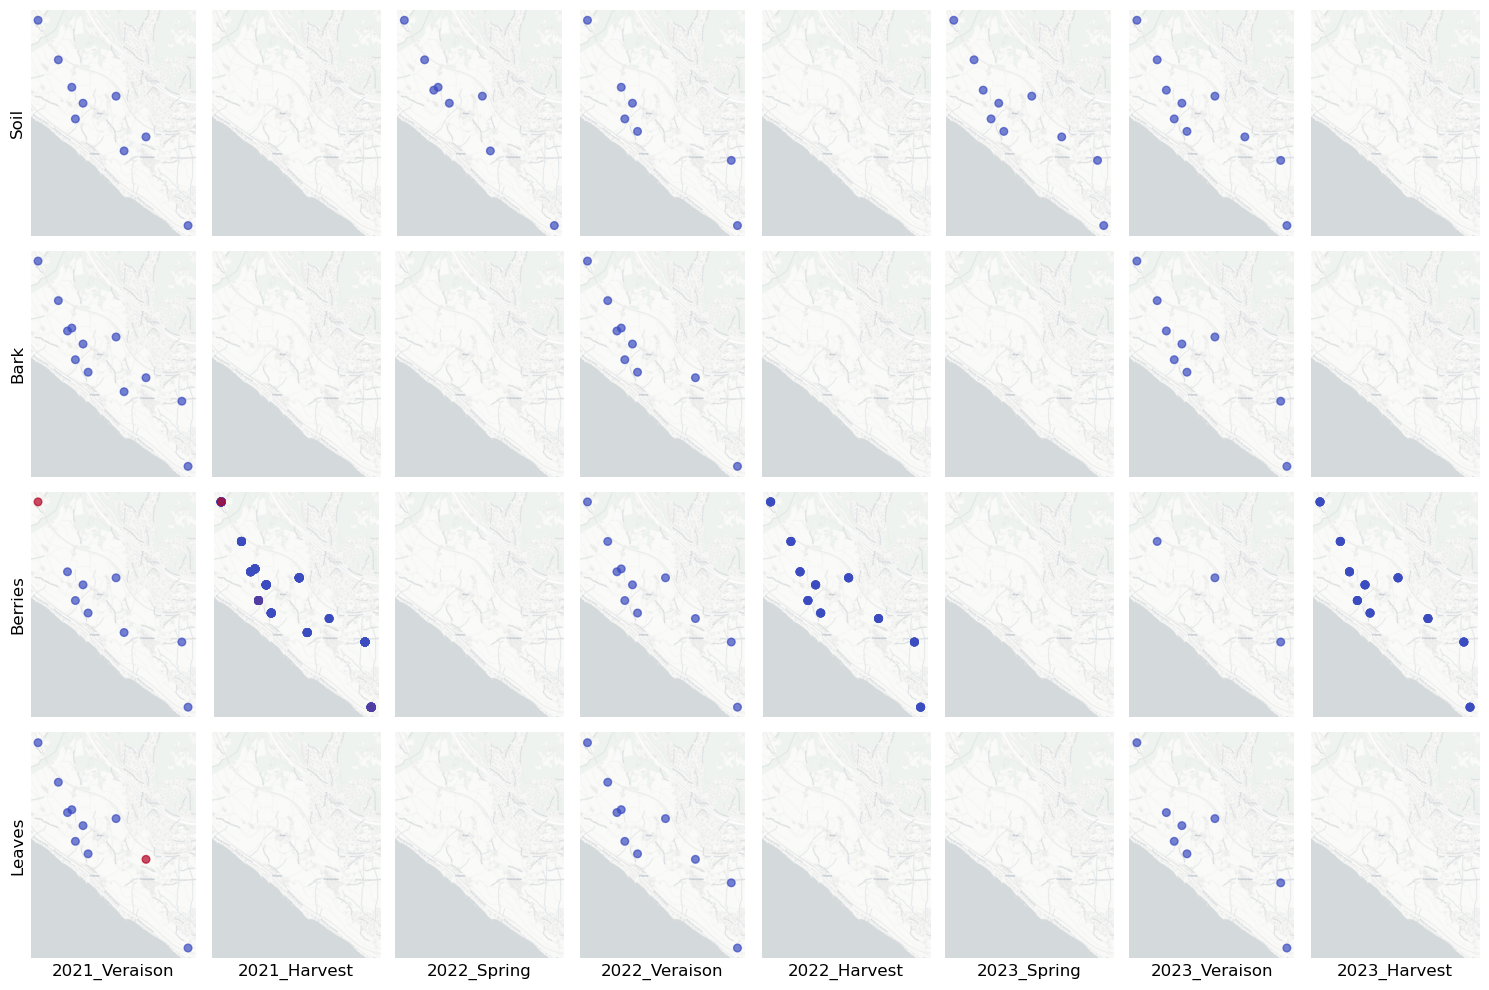

In [100]:
# Define the specific order of Time_Year and sample types
time_year_order = ['2021_Veraison', '2021_Harvest', '2022_Spring', '2022_Veraison', 
                   '2022_Harvest', '2023_Spring', '2023_Veraison', '2023_Harvest']
sample_types = ['soil', 'bark', 'berries', 'leaves']

# Create a plot with 4 rows and 8 columns
fig, axes = plt.subplots(4, 8, figsize=(15, 10), sharex=True, sharey=True)

# Loop through the sample types and time points
for i, sample_type in enumerate(sample_types):
    for j, time_year in enumerate(time_year_order):
        ax = axes[i, j]
        
        # Filter data for the specific Time_Year and sample type
        gdf_time_sample = gdf_samples[(gdf_samples['Time_Year'] == time_year) & (gdf_samples['sample_type'] == sample_type)]
        
        if not gdf_time_sample.empty:  # Only plot if there's data for this combination
            # Plot binary feature (Presence = 1, Absence = 0)
            gdf_time_sample.plot(ax=ax, column='binary_feature', cmap='coolwarm', markersize=30, legend=False, alpha=0.7)
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)
        
        # Remove axes labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

# Label the rows (sample types)
for i, sample_type in enumerate(sample_types):
    axes[i, 0].set_ylabel(sample_type.capitalize(), fontsize=12)

# Label the columns (Time_Year)
for j, time_year in enumerate(time_year_order):
    axes[-1, j].set_xlabel(time_year, fontsize=12)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()


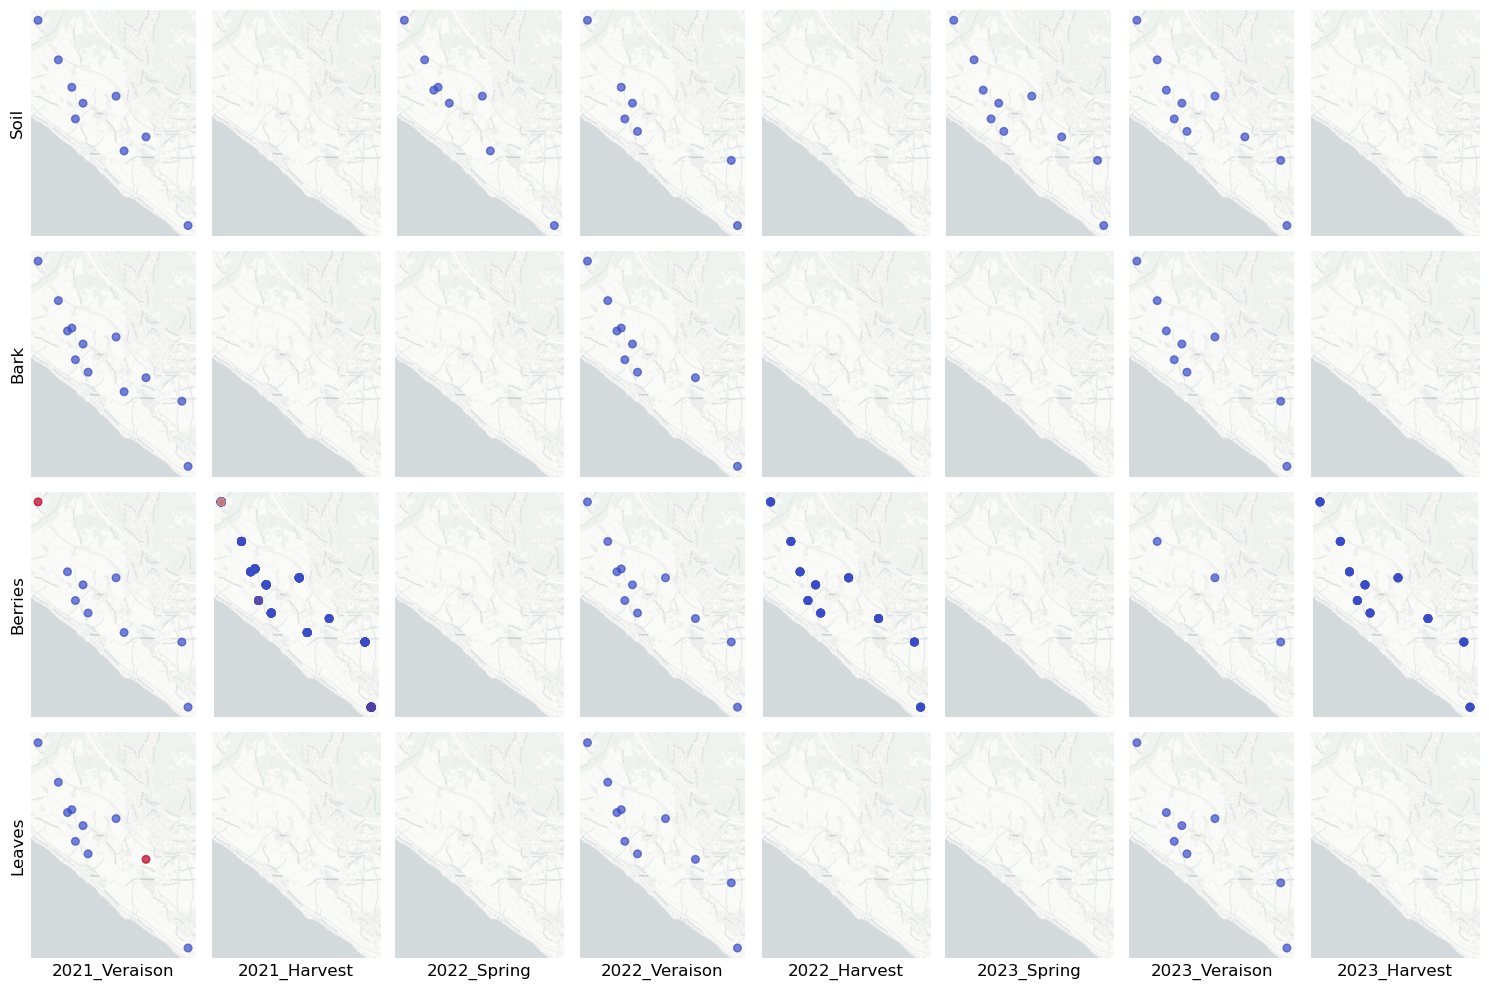

In [101]:

# Define the specific order of Time_Year and sample types
time_year_order = ['2021_Veraison', '2021_Harvest', '2022_Spring', '2022_Veraison', 
                   '2022_Harvest', '2023_Spring', '2023_Veraison', '2023_Harvest']
sample_types = ['soil', 'bark', 'berries', 'leaves']

# Create a plot with 4 rows and 8 columns
fig, axes = plt.subplots(4, 8, figsize=(15, 10), sharex=True, sharey=True)

# Loop through the sample types and time points
for i, sample_type in enumerate(sample_types):
    for j, time_year in enumerate(time_year_order):
        ax = axes[i, j]
        
        # Filter data for the specific Time_Year and sample type
        gdf_time_sample = gdf_samples[(gdf_samples['Time_Year'] == time_year) & (gdf_samples['sample_type'] == sample_type)]
        
        if not gdf_time_sample.empty:  # Only plot if there's data for this combination
            gdf_time_sample.plot(ax=ax, column='log2_feature', cmap='coolwarm', markersize=30, legend=False, alpha=0.7)
        
        # Add basemap
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, attribution=False)
        
        # Remove axes labels and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_frame_on(False)

# Label the rows (sample types)
for i, sample_type in enumerate(sample_types):
    axes[i, 0].set_ylabel(sample_type.capitalize(), fontsize=12)

# Label the columns (Time_Year) at the top
for j, time_year in enumerate(time_year_order):
    axes[3, j].set_xlabel(time_year, fontsize=12)

# Tight layout to adjust spacing
plt.tight_layout()
plt.show()